In [1]:
import os, time
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#import tensorflow as tf
#from tensorflow import keras

In [2]:
ONEDRIVE = os.getenv("OneDrive")
SRC_PATH = os.path.join(ONEDRIVE, 'src\\rule-switch-task')

EPHYS_PATH = os.path.join(ONEDRIVE, 'project\\ruleswitch\\data_ephys')
BEHAVIOR_PATH = os.path.join(ONEDRIVE, 'project\\ruleswitch\\data_behavior')
RESULT_PATH = os.path.join(ONEDRIVE, 'project\\ruleswitch\\result')

In [3]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], sio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, sio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            else:
                d[strg] = elem
        return d

    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

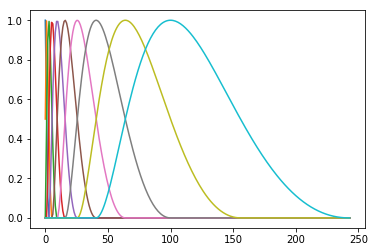

In [24]:
class LogBump():
    import numpy as np
    import matplotlib.pyplot as plt
    
    def __init__(self, n_bump=10, peak_edge=[0,100], bias=2, normalize=True): 
        # n_bump: number of cosine bumps
        # peak_edge: initial and last peak value
        # bias: make it more linear if it is higher
        
        # converting functions
        self.log_func = lambda x: np.log(x + 1e-3)
        self.exp_func = lambda x: np.exp(x) - 1e-3
        
        # set parameters
        self.n_bump = n_bump
        self.bias = bias
        
        self.peak_range = np.clip(np.array(peak_edge) + self.bias, 0, np.inf)
        self.peak_range_log = self.log_func(self.peak_range)
        self.peak_log, self.gap_log = np.linspace(self.peak_range_log[0], self.peak_range_log[1], self.n_bump, retstep=True)
        self.range_log = self.peak_range_log + np.array([-2, 2])*self.gap_log
        self.range = np.clip(self.exp_func(self.range_log) - self.bias, 0, np.inf)
        self.weights = np.ones(self.n_bump)
                
        # raised cosine function
        self.cos_func = lambda x, peak: (np.cos(np.clip((self.log_func(x + self.bias)-peak)*np.pi/(2*self.gap_log), -np.pi, np.pi))+1)/2
        
        self.x = np.arange(self.range[0], self.range[1]+1)
        self.y = self.calc(self.x)
        
        if normalize:
            self.weights = np.sum(self.y, 0)
            self.y /= self.weights
        
    def __call__(self, x):
        return self.calc(x)
    
    
    def calc(self, x):
        x_mat = np.tile(x, (self.n_bump, 1)).T
        peak_mat = np.tile(self.peak_log, (x.shape[0], 1))
        return self.cos_func(x_mat, peak_mat) / self.weights
        
        
    def plot(self, x=None):
        if x is None:
            x = self.x
            y = self.y
        else:
            y = self.calc(x)
        
        plt.plot(x, y)
        plt.show()
        
log_bump = LogBump(10, [0, 100], 2, normalize=False)
log_bump.plot()

In [16]:
log_bump.y

array([[1.00000000e+00, 5.00000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.38061496e-01, 9.25896959e-01, 7.61938504e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.89720312e-01, 9.87686775e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.62383054e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.06935736e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

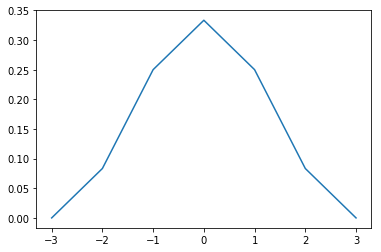

In [5]:
class LinearBump():
    import numpy as np
    import matplotlib.pyplot as plt
    
    def __init__(self, n_bump=9, bump_range=[-50,50], normalize=True): 
        # n_bump: number of cosine bumps
        # peak_edge: initial and last peak value
         
        # set parameters
        self.n_bump = n_bump
        self.range = np.array(bump_range)
        self.gap = np.diff(self.range) / (self.n_bump + 3)
        self.peak = np.linspace(self.range[0] + self.gap*2, self.range[1] - self.gap*2, self.n_bump)
        self.weight = np.ones(self.n_bump)
        
        # raised cosine function
        self.cos_func = lambda x, peak: (np.cos(np.clip((x-peak)*np.pi/(2*self.gap), -np.pi, np.pi))+1)/2
        
        self.x = np.arange(self.range[0], self.range[1]+1)
        y = self.calc(self.x)
        if normalize:
            self.weight = sum(y, 0)
        self.y = y / self.weight
        
    def __call__(self, x):
        return self.calc(x)
    
    def calc(self, x):
        x_mat = np.tile(x, (self.n_bump, 1)).T
        peak_mat = np.tile(self.peak, (x.shape[0], 1))
        return self.cos_func(x_mat, peak_mat) / self.weight
        
    def plot(self):
        plt.plot(self.x, self.y)
        plt.show()
        
lin_bump = LinearBump(1, [-3, 3])
lin_bump.plot()

In [6]:
i_file = 24

# file list
ephys_file = os.listdir(EPHYS_PATH)
ephys_file = [file_name for file_name in ephys_file if file_name.endswith('data.mat')]
n_file = len(ephys_file)

# load data
data = loadmat(os.path.join(EPHYS_PATH, ephys_file[i_file]))
print(ephys_file[i_file])

ANM421352_20180812_12P06R404V_g0_t0.imec.ap_imec3_opt3_data.mat


In [7]:
vr_time = data['Vr']['timeImec']
session_range = [data['Vr']['timeImec'][0], data['Vr']['timeImec'][-1]]
session_duration = np.diff(session_range)

vr_time = vr_time - session_range[0]

ball_speed = data['Vr']['ball_speed']
angle = data['Vr']['angle']
roll = data['Vr']['roll']
pitch = data['Vr']['pitch']
position = data['Vr']['position']

In [8]:
# split vr time bin
time_bin_s = np.arange(session_duration+1) # bin_size = 1 sec
n_time_bin_s = len(time_bin_s) - 1
inds = np.digitize(vr_time, time_bin_s)

# get speed in each time bin
speed_bin = np.zeros(n_time_bin_s)
for i_bin in range(n_time_bin_s):
    speed_bin[i_bin] = np.mean(ball_speed[inds==i_bin+1])

# categorize speed
speed_time_bin = np.arange(0, 50)
n_speed_time_bin = len(speed_time_bin) - 1
speed_index = np.digitize(speed_bin, speed_time_bin)

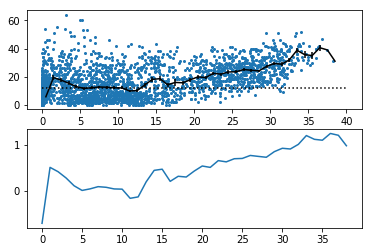

In [9]:
# load spike data
i_cell = 13
spike_time = data['Spike']['time'][i_cell]
in_spike = np.bitwise_and(spike_time>=session_range[0], spike_time<=session_range[1])
spike_time = spike_time[in_spike] - session_range[0]

# quantize spike
dtSp = 0.001
time_bin_ms = np.arange(0, session_duration, dtSp)
sps, _ = np.histogram(spike_time, time_bin_ms)
n_sps = len(sps)

mean_fr = np.mean(sps) / dtSp

# spike by speed
spike_bin, _ = np.histogram(spike_time, time_bin_s)
spike_mean = np.zeros(n_speed_time_bin)
spike_sem = np.zeros(n_speed_time_bin)
for i_bin in range(n_speed_time_bin):
    i_index = speed_index==i_bin+1
    if sum(i_index)==0:
        spike_mean[i_bin] = np.nan
        spike_sem[i_bin] = np.nan
        continue
    spike_mean[i_bin] = np.mean(spike_bin[i_index])
    spike_sem[i_bin] = np.std(spike_bin[i_index]) / np.sqrt(np.sum(i_index))

sta = spike_mean[np.arange(35)]

fig, ax = plt.subplots(2)
ax[0].scatter(speed_bin, spike_bin, s=4)
ax[0].errorbar(speed_time_bin[:-1]+0.5, spike_mean, yerr=spike_sem, color='k')
ax[0].plot([0, 40], [mean_fr, mean_fr], 'k:')

ax[1].plot(np.log(spike_mean / mean_fr))

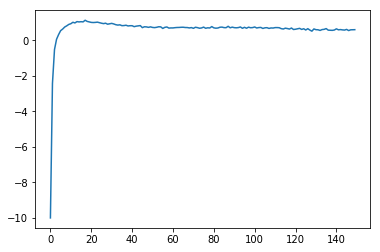

In [10]:
# cross_correlogram
sps_time = np.where(sps > 0)[0]
n_spike = len(sps_time)
n_time_bin = 150

spike_aligned = np.zeros((n_spike, n_time_bin))
for i_spike in range(n_spike):
    if sps_time[i_spike] > n_sps - n_time_bin - 1:
        spike_aligned[i_spike, 0:n_sps -
                      sps_time[i_spike] - 1] = sps[sps_time[i_spike]+1:]
    else:
        spike_aligned[i_spike, :] = sps[sps_time[i_spike] +
                                        1:sps_time[i_spike]+1+n_time_bin]
stc = np.log(np.mean(spike_aligned, 0) / (mean_fr * dtSp) + np.exp(-10))

plt.plot(stc)

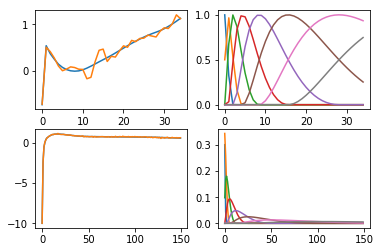

In [13]:
# make bump
n_speed = 8
n_h = 8

speed_bump = LogBump(n_speed, [0, 50], 1, normalize=False)
speed_base = speed_bump(np.arange(35))

h_bump = LogBump(n_h, [0, 100], 1)
h_base = h_bump(np.arange(1, 151))

# calc weights
w_speed0 = np.linalg.pinv(speed_base.T @ speed_base) @ (speed_base.T @ np.log(sta / mean_fr))
w_h0 = np.linalg.pinv(h_base.T @ h_base) @ (h_base.T @ stc)

# calc starting kernels
speed0 = speed_base @ w_speed0
h0 = h_base @ w_h0
c0 = np.log(np.mean(sps))

fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(speed0)
ax[0, 0].plot(np.log(sta/mean_fr))

ax[0, 1].plot(speed_base)

ax[1, 0].plot(h0)
ax[1, 0].plot(stc)

ax[1, 1].plot(h_base)

In [21]:
## prepare data for keras
# convolve speed
speed_filter = LinearBump(1, [-3, 3])
speed_temp_conv = np.convolve(ball_speed, np.squeeze(speed_filter.y), 'same')
speed_bin = np.interp(time_bin_ms[:-1]+dtSp/2, vr_time, speed_temp_conv)

X_speed = speed_bump(speed_bin).astype(np.float32)

# convolve h
X_h = np.zeros((n_sps, n_h), dtype=np.float32)
for i_h in range(n_h):
    X_h_temp = np.convolve(sps, h_base[:, i_h])
    X_h[:, i_h] = np.append(0, X_h_temp[0:-n_time_bin])

y = sps.astype(np.float32)

In [15]:
input_h = keras.layers.Input(shape=(n_h,))
input_speed = keras.layers.Input(shape=(n_speed,))

input_all = keras.layers.concatenate([input_speed, input_h])
output = keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(1e-5))(input_all)

model = keras.models.Model(inputs=[input_speed, input_h], outputs=output)

optimizer = tf.train.AdamOptimizer(
    learning_rate=0.0027, beta1=0.89, beta2=0.9999)
model.compile('adam', loss=tf.nn.log_poisson_loss)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 16)           0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            17          concatenate[0][0]                
Total para

In [26]:
# run model
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-5)
history = model.fit([X_speed, X_h], y, batch_size=4098, epochs=50, validation_split=0.2, callbacks=[early_stop])

Train on 3156962 samples, validate on 789241 samples
Epoch 1/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0579 - val_loss: 0.0702
Epoch 2/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0579 - val_loss: 0.0702
Epoch 3/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0579 - val_loss: 0.0702
Epoch 4/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0579 - val_loss: 0.0701
Epoch 5/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0579 - val_loss: 0.0701
Epoch 6/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0578 - val_loss: 0.0701
Epoch 7/50
3156962/3156962 [==============================] - 8s 3us/sample - loss: 0.0578 - val_loss: 0.0701
Epoch 8/50
3156962/3156962 [==============================] - 9s 3us/sample - loss: 0.0578 - val_loss: 0.0701
Epoch 9/50
3156962/3156962 [==============================] - 9s 3u

In [27]:
model.get_weights()

[array([[-2.7102377 ],
        [-0.4848038 ],
        [-0.75033176],
        [-1.2343372 ],
        [-1.2398348 ],
        [-1.0411581 ],
        [-0.870206  ],
        [-0.40321532],
        [-1.0478426 ],
        [-2.5057266 ],
        [-1.5893935 ],
        [ 1.6633211 ],
        [ 4.275904  ],
        [ 3.8712797 ],
        [ 2.7901652 ],
        [ 1.5613941 ]], dtype=float32), array([-2.3720465], dtype=float32)]

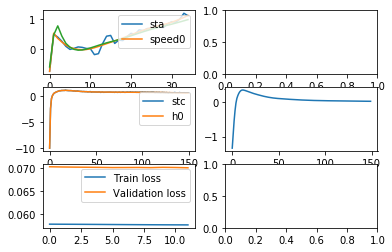

In [41]:
# unwrap weights
w_speed1 = model.get_weights()[0][0:n_speed]
w_h1 = model.get_weights()[0][n_speed:n_speed+n_h+1]
w_hc1 = model.get_weights()[1]

speed1 = speed_base @ w_speed1
h1 = h_base @ w_h1

# plot
_, ax = plt.subplots(3, 2)
ax[0, 0].plot(np.log(sta/mean_fr), label='sta')
ax[0, 0].plot(speed0, label='speed0')
ax[0, 0].legend(loc=1)
ax[0, 0].plot(speed1 - w_hc1, label='speed1')

ax[1, 0].plot(stc, label='stc')
ax[1, 0].plot(h0, label='h0')
ax[1, 0].legend(loc=1)
ax[1, 1].plot(h1, label='h1')

ax[2, 0].plot(history.history["loss"], label='Train loss')
ax[2, 0].plot(history.history["val_loss"], label='Validation loss')
ax[2, 0].legend(loc=1)
plt.show()

In [45]:
np.exp(w_hc1)/dtSp

array([93.28961], dtype=float32)

In [46]:
mean_fr

11.602038719244803